# 🌍 World Happiness Report

## Exploratory Data Analysis

### Data Source & Analysis Objective

#### Data Source
본 분석은 World Happiness Report 공개 데이터를 기반으로 합니다.<br />
데이터에는 국가별 행복 점수(Happiness Score)와 행복 순위(Happiness Rank)가 포함되어 있으며,<br />
CSV 형식으로 제공되어 국가 단위 분석이 가능합니다.

본 노트북에서는 Kaggle에 공개된 다음의 데이터셋을 사용합니다.

---

##### Data
* **2015 ~ 2019**: https://www.kaggle.com/datasets/unsdsn/world-happiness
* **2020 ~ 2024**: https://www.kaggle.com/datasets/samithsachidanandan/world-happiness-report-2020-2024

---

#### Analysis Objective
본 분석의 목적은 다음과 같습니다.
- 데이터의 기본 구조 및 품질 확인
- 결측치와 이상치 분포 파악
- 전 세계 국가별 행복 점수와 순위를 지도 시각화로 비교

### Environment & Libraries
본 노트북은 개인 로컬 환경의 Jupyter Notebook에서 실행되었으며,
탐색적 데이터 분석(EDA), 통계적 시각화,
그리고 전 세계 지리적 데이터 시각화를 위해
표준 Python 라이브러리를 사용합니다.

사용된 라이브러리는 추후 Kaggle 노트북 환경에서도
호환 가능하도록 구성되었습니다.

In [48]:
# ==================================================
# Core libraries
# Numerical computation & tabular data handling
# 수치 연산 및 테이블 형태 데이터 처리를 위한 라이브러리
# ==================================================
import numpy as np
import pandas as pd

# ==================================================
# Visualization libraries
# Statistical plots & EDA charts
# 통계 그래프 및 EDA 시각화를 위한 라이브러리
# ==================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from shapely.geometry import box

# ==================================================
# Geospatial libraries
# World map visualization & country matching
# 세계 지도 시각화 및 국가명/국가 코드 매핑을 위한 라이브러리
# ==================================================
import geopandas as gpd
import country_converter as coco

# ==================================================
# Utilities
# Warning control & notebook settings
# 경고 메시지 제어 및 노트북 실행 환경 설정
# ==================================================
import warnings
import math

from IPython.core.completer import not_found

warnings.filterwarnings("ignore")

#### Visualization Settings

Matplotlib에서 한글이 정상적으로 표시되도록 <br />
실행 환경에 따라 사용 가능한 한글 폰트를 자동으로 설정합니다. <br />
또한 음수 기호(−)가 깨지는 문제를 방지하기 위해 관련 설정을 함께 적용합니다.

In [49]:
import matplotlib.font_manager as fm    # Matplotlib에서 폰트 설정을 위해 font manager 호출

# 후보 폰트 목록 (환경별 대응)
font_candidates = [
    "NanumGothic",      # Linux / Kaggle
    "AppleGothic",     # macOS
    "Malgun Gothic"    # Windows
]

# 시스템에서 사용 가능한 폰트 목록을 dict 형태로 저장
available_fonts = {f.name: f.fname for f in fm.fontManager.ttflist}

# 후보 폰트 중 사용 가능한 폰트를 찾아 적용한 뒤 반복문 종료
for font in font_candidates:
    if font in available_fonts:
        plt.rcParams["font.family"] = font
        break

# 마이너스 기호(−)가 깨지는 현상 방지
plt.rcParams["axes.unicode_minus"] = False

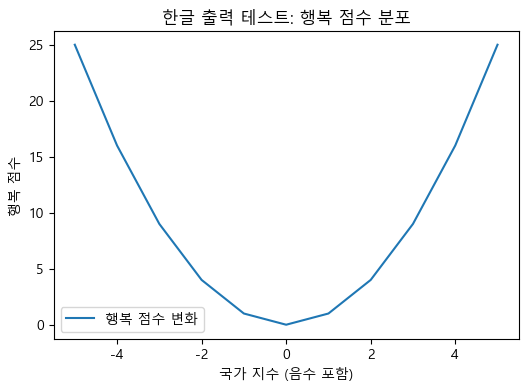

In [50]:
# font 적용 테스트
# 테스트 데이터
x = np.arange(-5, 6)
y = x ** 2

plt.figure(figsize=(6, 4))
plt.plot(x, y, label="행복 점수 변화")
plt.title("한글 출력 테스트: 행복 점수 분포")
plt.xlabel("국가 지수 (음수 포함)")
plt.ylabel("행복 점수")
plt.legend()
plt.show()

### Data Loading & Overview

#### Happiness Dataset

In [51]:
happiness_2015_df = pd.read_csv('../data/2015.csv')

##### Missing Values Analysis

In [52]:
# Dataset structure overview
happiness_2015_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        158 non-null    str    
 1   Region                         158 non-null    str    
 2   Happiness Rank                 158 non-null    int64  
 3   Happiness Score                158 non-null    float64
 4   Standard Error                 158 non-null    float64
 5   Economy (GDP per Capita)       158 non-null    float64
 6   Family                         158 non-null    float64
 7   Health (Life Expectancy)       158 non-null    float64
 8   Freedom                        158 non-null    float64
 9   Trust (Government Corruption)  158 non-null    float64
 10  Generosity                     158 non-null    float64
 11  Dystopia Residual              158 non-null    float64
dtypes: float64(9), int64(1), str(2)
memory usage: 14.9 KB


In [53]:
# Statistical summary
happiness_2015_df.describe()

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,79.493671,5.375734,0.047885,0.846137,0.991046,0.630259,0.428615,0.143422,0.237296,2.098977
std,45.754363,1.145010,0.017146,0.403121,0.272369,0.247078,0.150693,0.120034,0.126685,0.553550
min,1.000000,2.839000,0.018480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580
25%,40.250000,4.526000,0.037268,0.545808,0.856823,0.439185,0.328330,0.061675,0.150553,1.759410
50%,79.500000,5.232500,0.043940,0.910245,1.029510,0.696705,0.435515,0.107220,0.216130,2.095415
75%,118.750000,6.243750,0.052300,1.158448,1.214405,0.811013,0.549092,0.180255,0.309883,2.462415
max,158.000000,7.587000,0.136930,1.690420,1.402230,1.025250,0.669730,0.551910,0.795880,3.602140


In [54]:
# Statistical summary dtype string
happiness_2015_df.describe(include='str')

,Country,Region
count,158,158
unique,158,10
top,Switzerland,Sub-Saharan Africa
freq,1,40


In [55]:
# Missing values check
happiness_2015_df.isna().sum()

Country                          0
Region                           0
Happiness Rank                   0
Happiness Score                  0
Standard Error                   0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
dtype: int64

##### Detailed Outlier Analysis

In [56]:
# happiness_2015_df number columns
numeric_cols = happiness_2015_df.select_dtypes(include='number').columns

numeric_cols

Index(['Happiness Rank', 'Happiness Score', 'Standard Error',
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity',
       'Dystopia Residual'],
      dtype='str')

In [57]:
# numeric_cols의 길이를 n_plot에 저장
n_plot = len(numeric_cols)

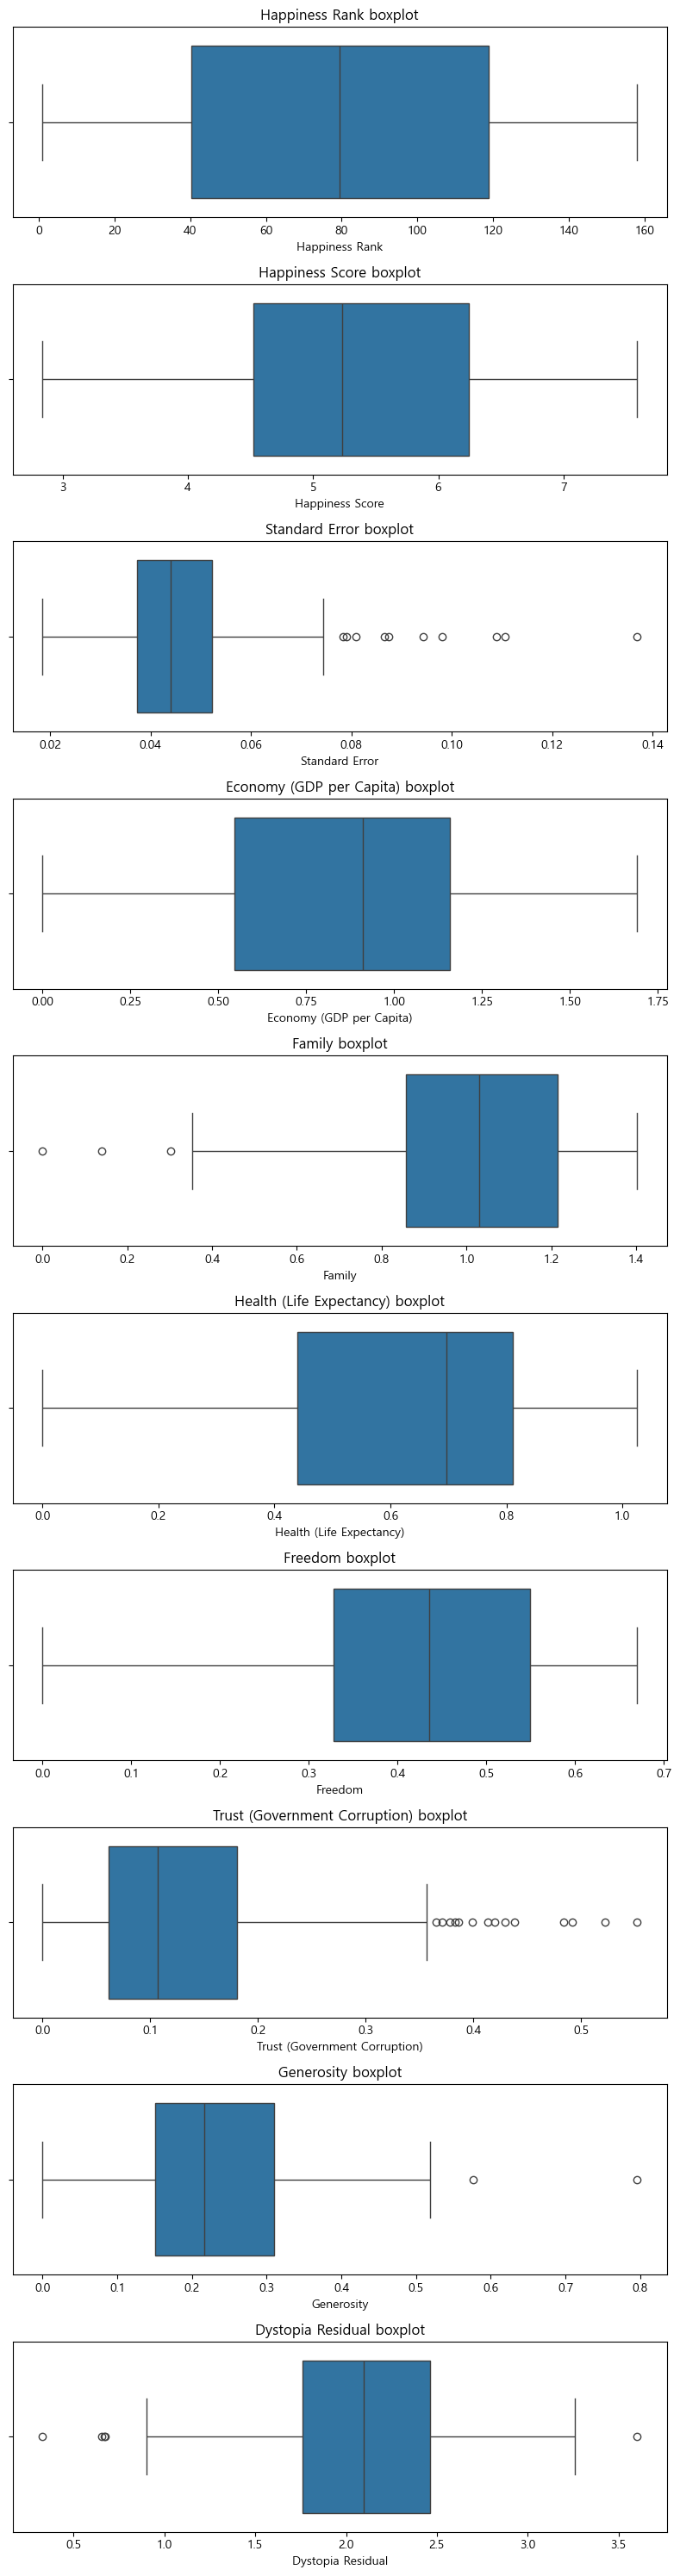

In [58]:
# 팔레트 설정
fig, axes = plt.subplots(
    nrows=n_plot,               # 행을 n_plot만큼 설정
    ncols=1,                    # 열은 1개로 설정
    figsize=(8, 3 * n_plot),    # 사이즈를 좌우는 8, 상하는 n_plot의 갯수에 3을 곱한 만큼
)

# 1 개 일 때도 대응
if n_plot == 1:
    axes = [axes]

# 그래프 출력
for ax, col in zip(axes, numeric_cols):
    sns.boxplot(
        x=happiness_2015_df[col],
        ax=ax,
    )
    ax.set_title(f'{col} boxplot')
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

##### Missing Values & Outliers Summary

수치형 변수 전반에 대해 boxplot을 통해 분포를 확인한 결과,<br />
일부 변수에서 극단값(outliers)이 관찰되었다.<br /><br />
**Standard Error, Trust (Government Corruption),<br />
Generosity 등의 변수에서는 상위 방향으로 치우친 값이 일부 존재**하며,<br />
이는 변수 특성상 **국가 간 편차가 크게 나타날 수 있는 지표로 해석**된다.<br /><br />
**본 분석 단계에서는 이러한 이상치를 즉시 제거하지 않고,<br />
각 변수 간 상관관계(correlation) 및<br />
Happiness Score에 미치는 영향도를 추가로 확인한 후,<br />
분석 목적에 따라 처리 여부를 결정할 예정**이다.

#### Geospatial Dataset

In [59]:
# load for dataset
world_df = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")

##### Missing Values Analysis

In [60]:
# Dataset structure overview
world_df.info(verbose=True, show_counts=True, max_cols=None)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 169 columns):
 #    Column      Non-Null Count  Dtype   
---   ------      --------------  -----   
 0    featurecla  177 non-null    str     
 1    scalerank   177 non-null    int32   
 2    LABELRANK   177 non-null    int32   
 3    SOVEREIGNT  177 non-null    str     
 4    SOV_A3      177 non-null    str     
 5    ADM0_DIF    177 non-null    int32   
 6    LEVEL       177 non-null    int32   
 7    TYPE        177 non-null    str     
 8    TLC         176 non-null    str     
 9    ADMIN       177 non-null    str     
 10   ADM0_A3     177 non-null    str     
 11   GEOU_DIF    177 non-null    int32   
 12   GEOUNIT     177 non-null    str     
 13   GU_A3       177 non-null    str     
 14   SU_DIF      177 non-null    int32   
 15   SUBUNIT     177 non-null    str     
 16   SU_A3       177 non-null    str     
 17   BRK_DIFF    177 non-null    int32   
 18   NAME        177 non-

In [61]:
# Statistical summary dtype string
world_df.describe(include='str')

,featurecla,SOVEREIGNT,SOV_A3,TYPE,TLC,ADMIN,ADM0_A3,GEOUNIT,GU_A3,SUBUNIT,...,FCLASS_VN,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA
count,177,177,177,177,176,177,177,177,177,177,...,3,4,5,4,3,3,4,3,6,3
unique,1,171,171,6,1,177,177,177,177,177,...,1,2,2,2,1,2,2,2,3,1
top,Admin-0 country,France,FR1,Sovereign country,1,Fiji,FJI,Fiji,FJI,Fiji,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized
freq,177,3,3,156,176,1,1,1,1,1,...,3,2,4,3,3,2,3,2,3,3


##### Missing valuse Summary

본 섹션에서는 세계 지도 시각화를 위해 사용될 지리 데이터셋의
구조와 주요 컬럼을 확인한다.
해당 데이터는 분석 대상이 아닌 참조용 메타데이터로 활용된다

### Correlation Analysis (Based on Happiness Score)

본 데이터셋에서 **Happiness Rank는 Happiness Score를 기준으로 산출된 순위형 지표이므로 상관관계 분석에서는 중복 정보를 피하기 위해**<br />
연속형 변수인 **Happiness Score를 기준으로 변수 간 상관관계를 파악**한다.

In [62]:
# object dtype(str)은 제외하고 numeric dtype으로만 상관관계를 분석하기 위해서
corr_summary_df = (
    happiness_2015_df.select_dtypes(include='number')
    .drop(columns=['Happiness Rank'], errors='ignore')
    .rename(columns={'Happiness Score' : 'Correlation with Score'})
    .corr()
    .copy()
)

In [63]:
# dataframe 확인
corr_summary_df.head()

,Correlation with Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Correlation with Score,1.000000,-0.177254,0.780966,0.740605,0.724200,0.568211,0.395199,0.180319,0.530474
Standard Error,-0.177254,1.000000,-0.217651,-0.120728,-0.310287,-0.129773,-0.178325,-0.088439,0.083981
Economy (GDP per Capita),0.780966,-0.217651,1.000000,0.645299,0.816478,0.370300,0.307885,-0.010465,0.040059
Family,0.740605,-0.120728,0.645299,1.000000,0.531104,0.441518,0.205605,0.087513,0.148117
Health (Life Expectancy),0.724200,-0.310287,0.816478,0.531104,1.000000,0.360477,0.248335,0.108335,0.018979


#### Visualization

##### plot chart

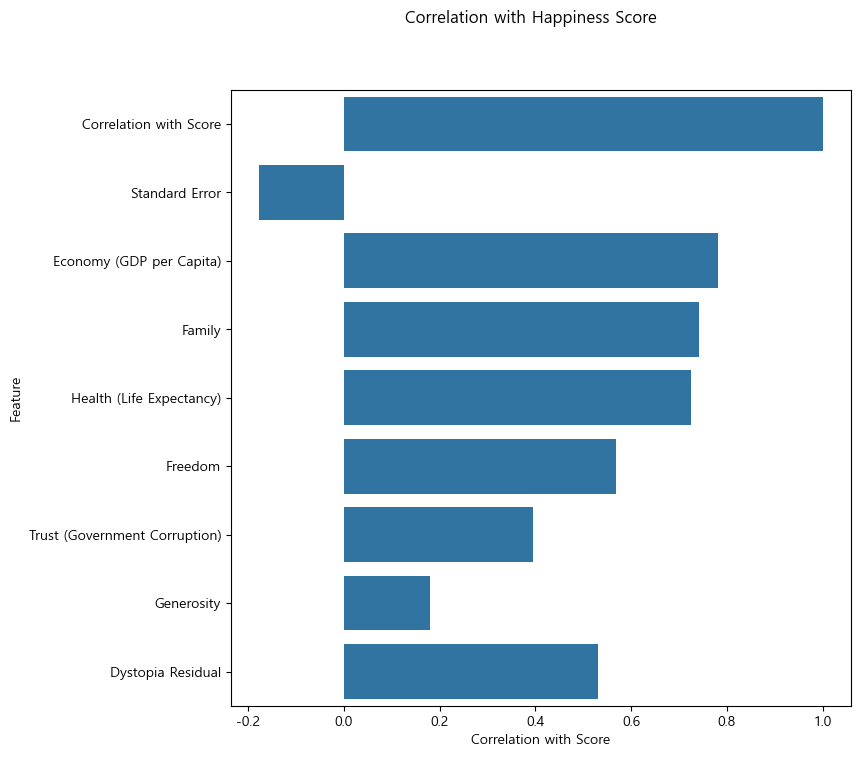

In [64]:
# 시각화 plot chart
plt.figure(figsize=(8,8))

sns.barplot(
    data=(
        corr_summary_df
        .reset_index()
        .rename(columns={'index' : 'Feature'})
    ),
    x = 'Correlation with Score',
    y = 'Feature',
    orient='h'
)

plt.suptitle('Correlation with Happiness Score')
plt.xlabel('Correlation with Score')
plt.ylabel('Feature')
plt.show()

##### heatmap chart

In [65]:
# 마스크: 윗 삼각형(대각선 위)을 숨기고 배경을 흰색으로 지정하기 위한 배열
mask_upper = np.triu(np.ones_like(corr_summary_df, dtype=bool), k=1)

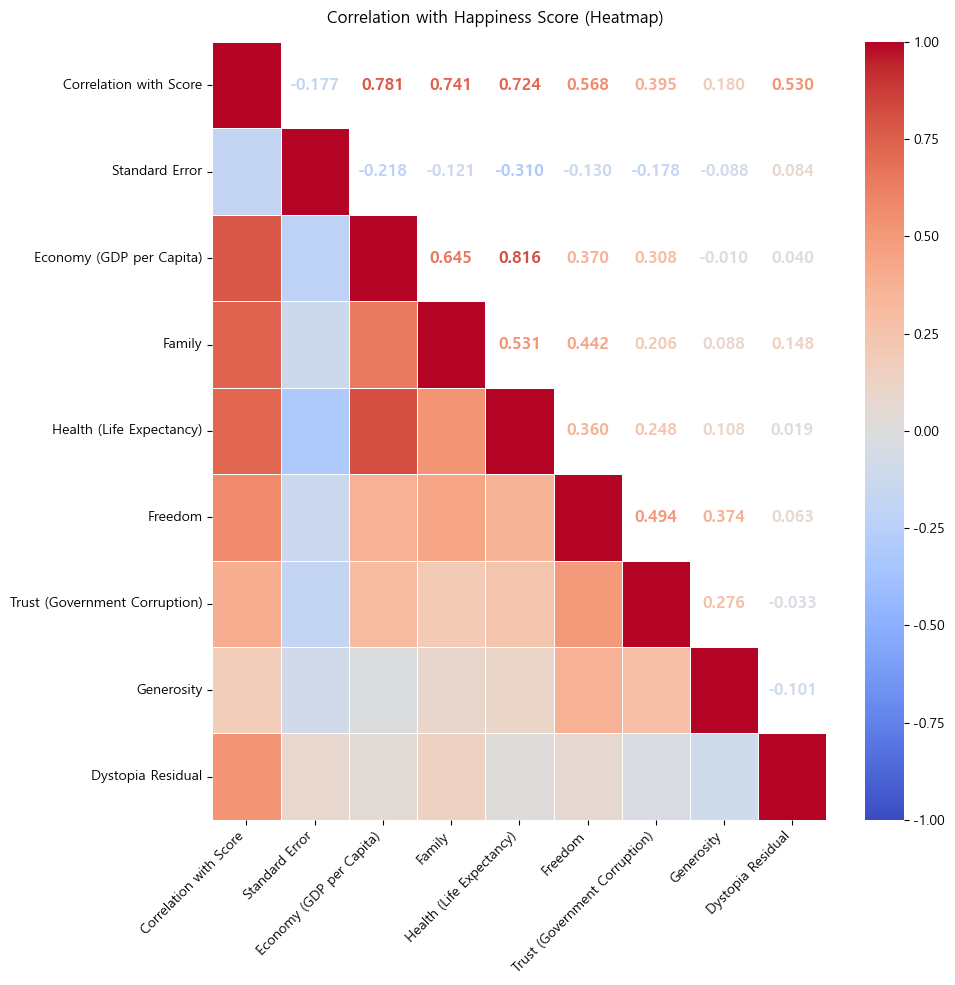

In [66]:
# 차트 생성
fig, ax = plt.subplots(figsize=(10, 10))

# heatmap을 1.0 아래 구역만 출력
sns.heatmap(
    corr_summary_df,
    mask=mask_upper,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    annot=False,
    linewidths=0.5,
    cbar=True,
    xticklabels=True, yticklabels=True,
    ax=ax,
)

# colormap & 정규화 객체
norm = mpl.colors.Normalize(vmin=-1, vmax=1)    # 상관 계수는 -1부터 1사이의 값 이므로 정규화 구간을 -1 ~ 1 사이로 설정
cmap = plt.get_cmap('coolwarm')                 # cmap을 plt에서 제공하는 coolwarm의 값을 취득

# 기존의 heatmap에서 1.0포함해서 위쪽 부분을 숫자로 출력
# ex: 'Correlation with Score'
row_idx = corr_summary_df.index.get_loc('Correlation with Score')

# 반목문으로 치환 작업
for i in range(len(corr_summary_df)):
    for j in range(i, len(corr_summary_df)):
        # dataframe에서 인덱스 지정으로 value를 취득
        value = corr_summary_df.iloc[i, j]

        # 해당 값의 색상을 지정
        rgba = cmap(norm(value))

        # 기존의 차트에 글자를 삽입
        ax.text(
            j + 0.5,
            i + 0.5,
            f'{value:.3f}',
            ha='center',
            va='center',
            fontdict={
                'color': rgba,
                'fontsize': 12,
                'fontweight': 'bold',
            },
    )

# 보기 좋게 x축 라벨을 45도 회전
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# title 설정
plt.suptitle('Correlation with Happiness Score (Heatmap)')
plt.tight_layout()
plt.show()

#### Correlation Analysis (Based on Happiness Score) Summary

상관관계 시각화 결과로<br />
**1인당 GDP(Economy), 가족(Family), 기대 수명(Health)은 Happiness Score와 높은 양의 상관관계**를 보였다.<br /><br />
또한 **1인당 GDP와 기대 수명 간에도 상대적으로 강한 상관관계가 관찰**되었으며,<br />
이는 경제적 수준과 건강 지표가 행복 지수에 복합적으로 작용할 가능성을 시사한다.<br /><br />
이후 분석 단계에서는 양의 상관관계를 보인 **1인당 GDP, 기대 수명, 가족 지표를 중심으로** 추가 분석을 진행할 예정이다.<br /><br />
반면 **Standard Error는 Happiness Score와의 상관관계가 낮고<br />분석 목적과의 직접적인 연관성이 제한적이므로, 이후 분석 단계에서는 제외하고 진행한다.**

### Data Preparation & Merge

#### Data Preparation

In [67]:
# world_df select need columns copy
# world_df에서 ['NAME_EN', 'REGION_UN', 'SUBREGION', 'ECONOMY', 'ISO_A3', 'ADM0_A3', 'geometry']들을 복사
# ISO_A3는 국가 코드고 ADM0_A3는 분쟁 지역을 반영한 국가 코드다.
world_info_df = world_df.loc[
    :,
    ['NAME_EN', 'REGION_UN', 'SUBREGION', 'ECONOMY', 'ISO_A3', 'ADM0_A3', 'geometry']
].copy()

In [68]:
# dataframe split after dataframe structure
world_info_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   NAME_EN    177 non-null    str     
 1   REGION_UN  177 non-null    str     
 2   SUBREGION  177 non-null    str     
 3   ECONOMY    177 non-null    str     
 4   ISO_A3     177 non-null    str     
 5   ADM0_A3    177 non-null    str     
 6   geometry   177 non-null    geometry
dtypes: geometry(1), str(6)
memory usage: 9.8 KB


In [69]:
# dataframe columns rename
world_info_df = world_info_df.rename(
    columns={
        'NAME_EN': 'Country', 'REGION_UN':'Region',
        'SUBREGION': 'Sub_region', 'ECONOMY': 'Economy',
        'ISO_A3': 'ISO', 'ADM0_A3': 'ADM0', 'geometry': 'Geometry'
    })

In [70]:
# rename after dataframe structure
world_info_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Country     177 non-null    str     
 1   Region      177 non-null    str     
 2   Sub_region  177 non-null    str     
 3   Economy     177 non-null    str     
 4   ISO         177 non-null    str     
 5   ADM0        177 non-null    str     
 6   Geometry    177 non-null    geometry
dtypes: geometry(1), str(6)
memory usage: 9.8 KB


#### merged for world_info_df into happiness_2015_df

In [71]:
# happiness_2015_df column add ISO code
# ISO코드를 부여하고 ISO가 중복인 경우에는 ADM0 코드를 부여
# - ADM0는 분쟁 지역에 부여하는 국가 코드

# ISO코드가 중복되는 것을 ADM0 코드로 변경하고 Country_code 컬럼에 할당
world_info_df["Country_code"] = world_info_df["ISO"].where(
    world_info_df["ISO"].notna() & (world_info_df["ISO"] != "-99"),
    world_info_df["ADM0"]
)

In [72]:
# 결측치 확인
world_info_df['Country_code'].isna().sum()

np.int64(0)

In [73]:
# 이상치 확인
world_info_df.groupby("Country_code")["Country"].nunique().sort_values(ascending=False).head(10)

Country_code
AFG    1
AGO    1
ALB    1
ARE    1
ARG    1
ARM    1
ATA    1
ATF    1
AUS    1
AUT    1
Name: Country, dtype: int64

In [74]:
# 병합 전 world_info_df 구조확인
world_info_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Country       177 non-null    str     
 1   Region        177 non-null    str     
 2   Sub_region    177 non-null    str     
 3   Economy       177 non-null    str     
 4   ISO           177 non-null    str     
 5   ADM0          177 non-null    str     
 6   Geometry      177 non-null    geometry
 7   Country_code  177 non-null    str     
dtypes: geometry(1), str(7)
memory usage: 11.2 KB


In [75]:
# ISO코드 부여
happiness_2015_df["Country_code"] = coco.convert(
    names=happiness_2015_df['Country'],
    to="ISO3",
    not_found=None
)

In [76]:
# 중복되는 국가 코드 확인
dup_mask = happiness_2015_df['Country_code'].duplicated(keep=False)

In [77]:
happiness_2015_df["Country_code"].value_counts().loc[lambda x : x > 1]

Country_code
CYP    2
Name: count, dtype: int64

In [78]:
# 1) ADM0를 happiness_2015_df에 붙이기
happiness_2015_df = happiness_2015_df.merge(
    world_info_df[["Country", "ADM0"]],
    on="Country",
    how="left",
    suffixes=("", "_world")
)

In [79]:
# 3) 중복인 곳만 ADM0로 덮어쓰기
happiness_2015_df.loc[dup_mask, "Country_code"] = (
    happiness_2015_df.loc[dup_mask, "ADM0"].combine_first(
        happiness_2015_df.loc[dup_mask, "Country_code"]
    )
)

In [80]:
# 중복값 확인
happiness_2015_df["Country_code"].value_counts().loc[lambda x : x > 1]

Country_code
CYP    2
Name: count, dtype: int64

In [81]:
# 중복되는 컬럼 확인
overlap_cols = world_info_df.columns.intersection(happiness_2015_df.columns)

In [82]:
overlap_cols

Index(['Country', 'Region', 'ADM0', 'Country_code'], dtype='str')

In [83]:
# 병합할때 기준이 되는 열
key = 'Country_code'

# 열이름을 다시 지정
happiness_2015_clean_df = happiness_2015_df.rename(
    columns={c : f'{c}_2015' for c in overlap_cols if c != key}
).copy()

In [84]:
happiness_2015_clean_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country_2015                   158 non-null    str    
 1   Region_2015                    158 non-null    str    
 2   Happiness Rank                 158 non-null    int64  
 3   Happiness Score                158 non-null    float64
 4   Standard Error                 158 non-null    float64
 5   Economy (GDP per Capita)       158 non-null    float64
 6   Family                         158 non-null    float64
 7   Health (Life Expectancy)       158 non-null    float64
 8   Freedom                        158 non-null    float64
 9   Trust (Government Corruption)  158 non-null    float64
 10  Generosity                     158 non-null    float64
 11  Dystopia Residual              158 non-null    float64
 12  Country_code                   158 non-null    str    
 13  A

In [85]:
# meagre 진행
happiness_2015_geo_df = world_info_df.merge(
    happiness_2015_clean_df,
    how="left",
    on=key
).copy()

In [86]:
# merge 후 데이터 구조 파악
happiness_2015_geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Country                        178 non-null    str     
 1   Region                         178 non-null    str     
 2   Sub_region                     178 non-null    str     
 3   Economy                        178 non-null    str     
 4   ISO                            178 non-null    str     
 5   ADM0                           178 non-null    str     
 6   Geometry                       178 non-null    geometry
 7   Country_code                   178 non-null    str     
 8   Country_2015                   151 non-null    str     
 9   Region_2015                    151 non-null    str     
 10  Happiness Rank                 151 non-null    float64 
 11  Happiness Score                151 non-null    float64 
 12  Standard Error              

In [87]:
# Geometry 활성화
happiness_2015_geo_df = happiness_2015_geo_df.set_geometry('Geometry')

In [88]:
# 활성화 확인
happiness_2015_geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### visualization

#### happiness score

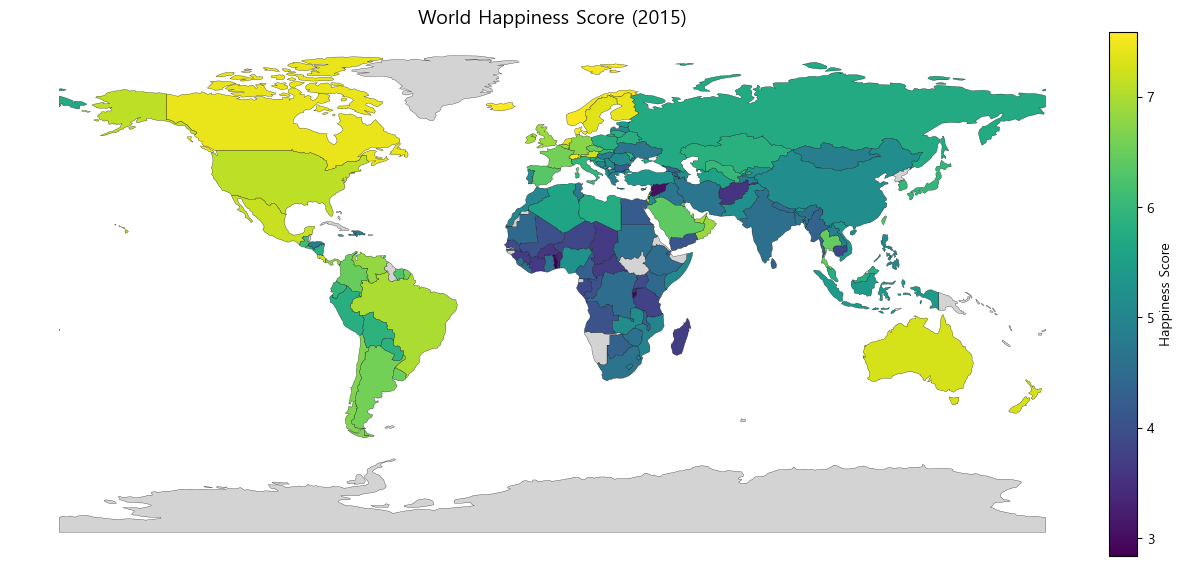

In [89]:
# 1) figure/ax 생성
fig, ax = plt.subplots(figsize=(14, 8))

# 2) 먼저 지도만 그리기 (legend=False)
happiness_2015_geo_df.plot(
    column="Happiness Score",
    ax=ax,
    cmap="viridis",
    legend=False,
    linewidth=0.2,
    edgecolor="black",
    missing_kwds={"color": "lightgrey"}
)

ax.set_title("World Happiness Score (2015)", fontsize=14)
ax.set_axis_off()

# 3) ax와 같은 높이로 colorbar 영역(cax) 만들기
pos = ax.get_position()               # 지도 축의 위치(figure 좌표)
pad = 0.01                            # 지도와 바 사이 간격(figure 비율)
cbar_w = 0.02                         # colorbar 너비(figure 비율)

cax = fig.add_axes([pos.x1 + pad, pos.y0, cbar_w, pos.height])

# 4) colorbar 생성 (mappable은 plot 결과에서 가져오기)
mappable = ax.collections[0]
cbar = fig.colorbar(mappable, cax=cax)
cbar.set_label("Happiness Score")

plt.show()

#### happiness rank

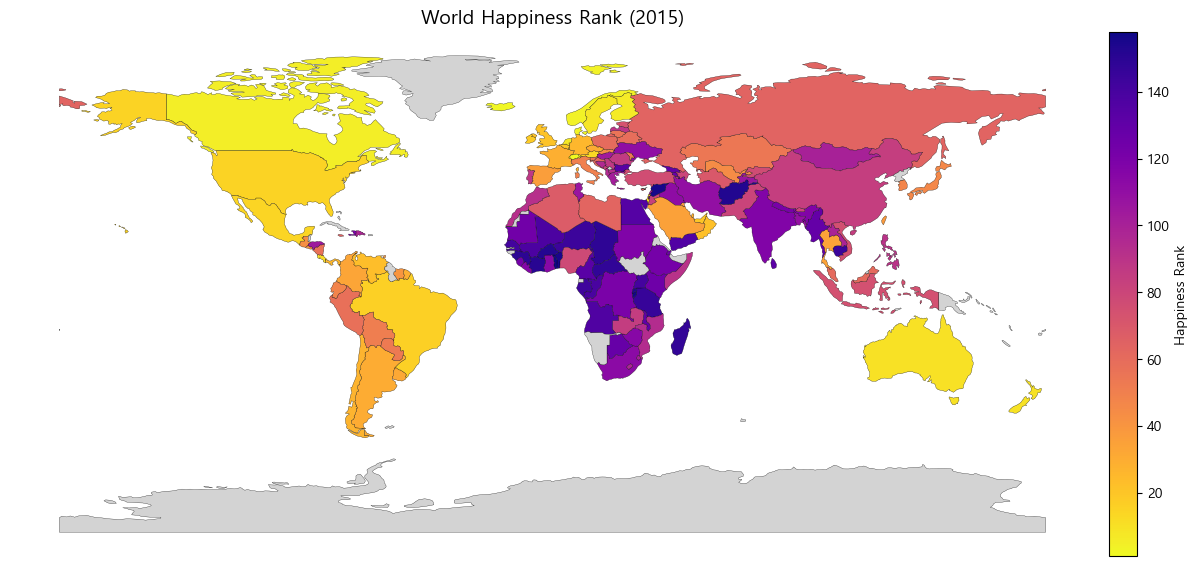

In [90]:
# 1) figure/ax 생성
fig, ax = plt.subplots(figsize=(14, 8))

# 2) 지도 그리기
happiness_2015_geo_df.plot(
    column="Happiness Rank",
    ax=ax,
    cmap="plasma_r",  # ⭐ reversed plasma
    legend=False,
    linewidth=0.2,
    edgecolor="black",
    missing_kwds={"color": "lightgrey"}
)

ax.set_title("World Happiness Rank (2015)", fontsize=14)
ax.set_axis_off()

# 3) colorbar 영역 생성
pos = ax.get_position()
pad = 0.01
cbar_w = 0.02

cax = fig.add_axes([pos.x1 + pad, pos.y0, cbar_w, pos.height])

# 4) colorbar 생성
mappable = ax.collections[0]
cbar = fig.colorbar(mappable, cax=cax)
cbar.set_label("Happiness Rank")

plt.show()

#### Region for asia

##### Happiness Score

In [91]:
# =========================
# 1) 대략적인 아시아 영역 (시베리아 포함)
# =========================
asia_bbox = box(30, 0, 180, 80)  # (min_lon, min_lat, max_lon, max_lat)

In [92]:
# =========================
# 2) 아시아 + 러시아 추출
# =========================
happiness_2015_asia_df = happiness_2015_geo_df[happiness_2015_geo_df["Region"] == "Asia"]
happiness_2015_russia_df = happiness_2015_geo_df[happiness_2015_geo_df["ISO"] == "RUS"]

# (안전) geometry 활성화가 혹시 풀렸을 때 대비
if "geometry" in happiness_2015_asia_df.columns:
    happiness_2015_asia_df = happiness_2015_asia_df.set_geometry("geometry")
if "geometry" in happiness_2015_russia_df.columns:
    happiness_2015_russia_df = happiness_2015_russia_df.set_geometry("geometry")


In [93]:
# =========================
# 3) Clip용 bbox GeoDataFrame
# =========================
asia_bbox_gdf = gpd.GeoDataFrame(
    geometry=[asia_bbox],
    crs=happiness_2015_geo_df.crs  # geo df의 crs를 따르는 게 가장 안전
)

In [94]:
# =========================
# 4) 러시아 중 아시아 bbox에 걸치는 부분(시베리아)만 clip
# =========================
russia_asia = gpd.clip(happiness_2015_russia_df, asia_bbox_gdf)

In [95]:
# =========================
# 5) 아시아 + 시베리아 합치기 (GeoDataFrame 유지)
# =========================
asia_with_siberia = gpd.GeoDataFrame(
    pd.concat([happiness_2015_asia_df, russia_asia], ignore_index=True),
    geometry="Geometry",
    crs=happiness_2015_geo_df.crs
)

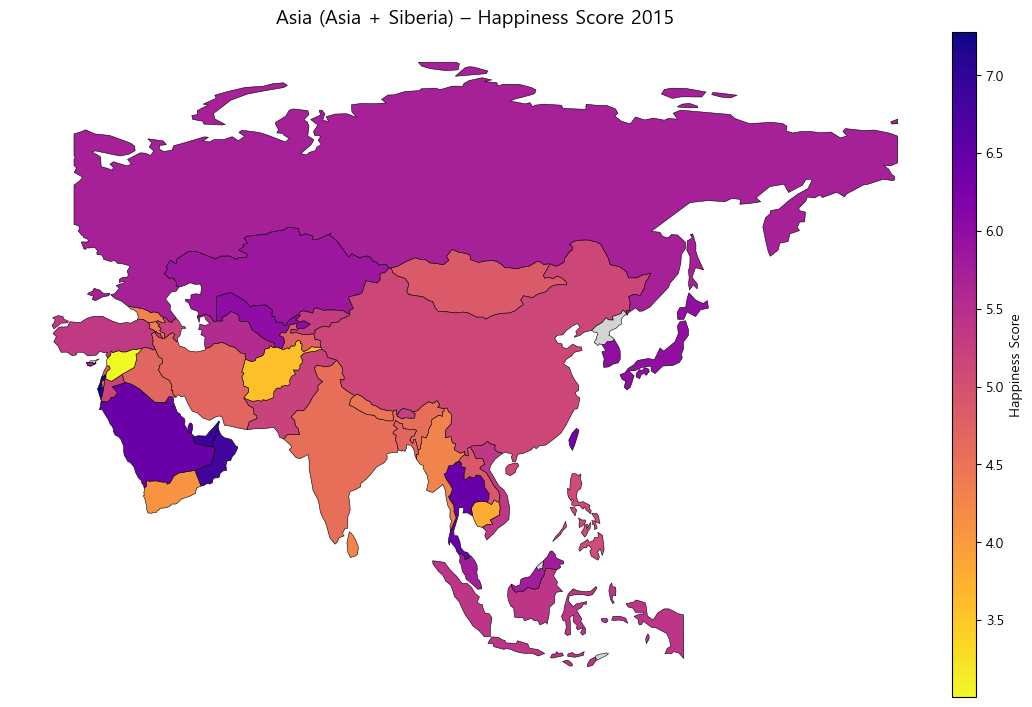

In [97]:
# =========================
# 6) Plot: Happiness Score + colorbar
# =========================
fig, ax = plt.subplots(figsize=(12, 12))

asia_with_siberia.plot(
    column='Happiness Score',
    ax=ax,
    cmap="plasma_r",
    edgecolor="black",
    linewidth=0.4,
    legend=False,  # colorbar는 수동으로
    missing_kwds={"color": "lightgrey"}
)

ax.set_title('Asia (Asia + Siberia) – Happiness Score 2015', fontsize=14)
ax.set_axis_off()

# --- colorbar (ax 높이 맞춤) ---
pos = ax.get_position()
pad = 0.01
cbar_w = 0.02
cax = fig.add_axes([pos.x1 + pad, pos.y0, cbar_w, pos.height])

mappable = ax.collections[0]
cbar = fig.colorbar(mappable, cax=cax)
cbar.set_label("Happiness Score")

plt.show()

#### Visualization Summary

2015년도 조사자료 기준으로 **북유럽(Northern Europe)과 북아메리카(North America) 지역이 행복지수가 높게** 나오고있다.<br />
또한 **아시아(Asia) 내부에서도 1인당 GDP가 높은 중동 지역이 행복지수가 높게** 나오고 있다.<br />
허나 **태국**처럼 1인당 GDP 수준만으로 설명하기 어려운 예외 사례가 존재하므로<br />
단순 비교보다는 **GDP·사회적 지원·기대수명·자유·부패 인식**등과 함계 **상관관계 및 다변량 관점에서 분석이 필요하다.**

### Correlation Analysis Between Happiness Score and Socioeconomic Indicators

#### GDP Correlation Analysis

In [101]:
# happiness_2015_df에서 문자열과 Rank, Strander Error를 제외하고 Score에 관련한 상관관계를 분리
happiness_2015_numeric_df = happiness_2015_df.select_dtypes(include='number').copy()

In [104]:
# Rank와 Standard Error 컬럼 제거
happiness_2015_numeric_df.drop(columns=['Happiness Rank', 'Standard Error'], inplace=True)

In [105]:
# data structure
happiness_2015_numeric_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Happiness Score                158 non-null    float64
 1   Economy (GDP per Capita)       158 non-null    float64
 2   Family                         158 non-null    float64
 3   Health (Life Expectancy)       158 non-null    float64
 4   Freedom                        158 non-null    float64
 5   Trust (Government Corruption)  158 non-null    float64
 6   Generosity                     158 non-null    float64
 7   Dystopia Residual              158 non-null    float64
dtypes: float64(8)
memory usage: 10.0 KB


##### visualization

In [114]:
# mean
gpd_mean = happiness_2015_numeric_df['Economy (GDP per Capita)'].mean()
score_mean = happiness_2015_numeric_df['Happiness Score'].mean()

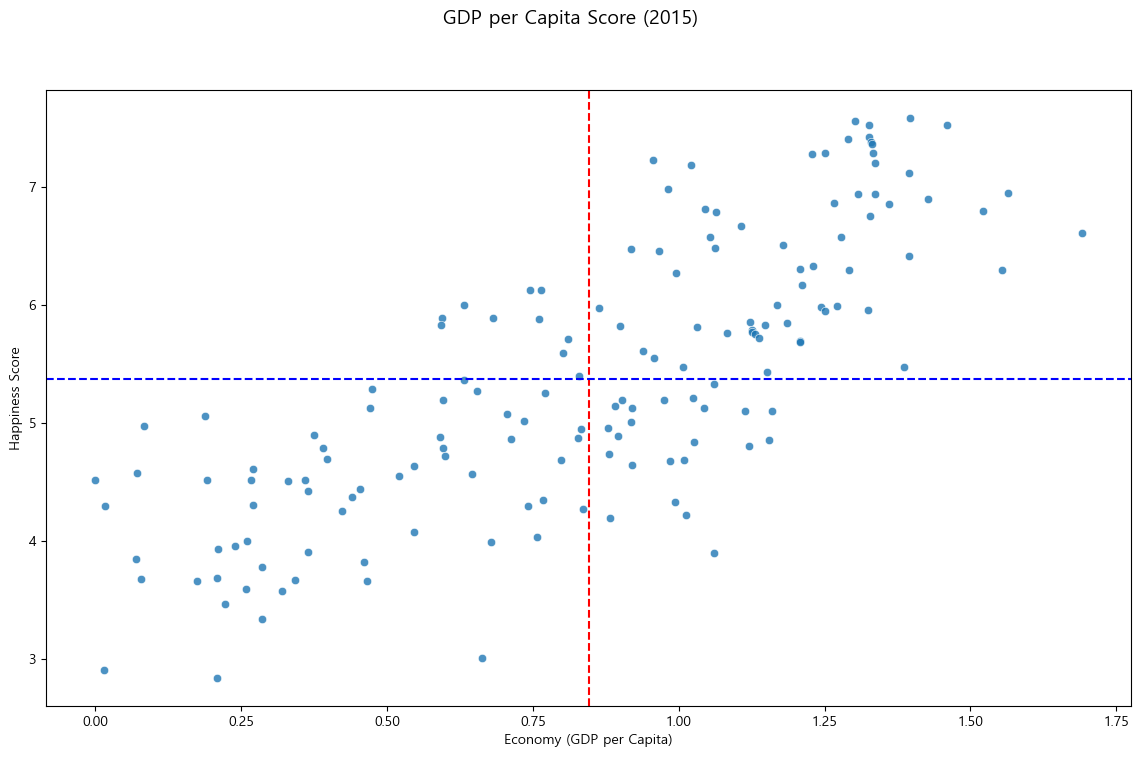

In [117]:
# scatter chart
plt.figure(figsize=(14, 8))

# scatter plot
sns.scatterplot(
    data=happiness_2015_numeric_df,
    x = 'Economy (GDP per Capita)',
    y = 'Happiness Score',
    alpha=0.8,
)

# 평균선 추가
plt.axvline(x=gpd_mean, color="red", linestyle="--", linewidth=1.5, label="Mean Economy (GDP per Capita)")
plt.axhline(y=score_mean, color="blue", linestyle="--", linewidth=1.5, label="Mean Happiness Score)")

# title
plt.suptitle('GDP per Capita Score (2015)', fontsize=14)
plt.show()

##### summary for GDP

그래프 기준으로 **좌상단(저 GDP·고 행복)과 우하단(고 GDP·저 행복)에 위치한 국가들**은<br /> 행복지수가 GDP 수준만으로는 충분히 설명되지 않는 예외 사례로 해석할 수 있다.<br /><br />
반면, **우상단(고 GDP·고 행복)과 좌하단(저 GDP·저 행복)에 분포한 국가들**은<br />
GDP와 행복지수 간의 전반적인 양의 상관관계 흐름을 따르는 경향을 보인다.<br /><br />
따라서 이후 분석에서는 이러한 예외 국가를 별도로 고려하고,
**GDP 이외의 요인(사회적 지원, 기대수명, 자유, 부패 인식 등)을 포함한 다변량 관점의 상관관계 분석이 필요**하다.

#### Family Correlation Analysis

##### visualization

In [111]:
# mean
family_mean = happiness_2015_numeric_df['Family'].mean()

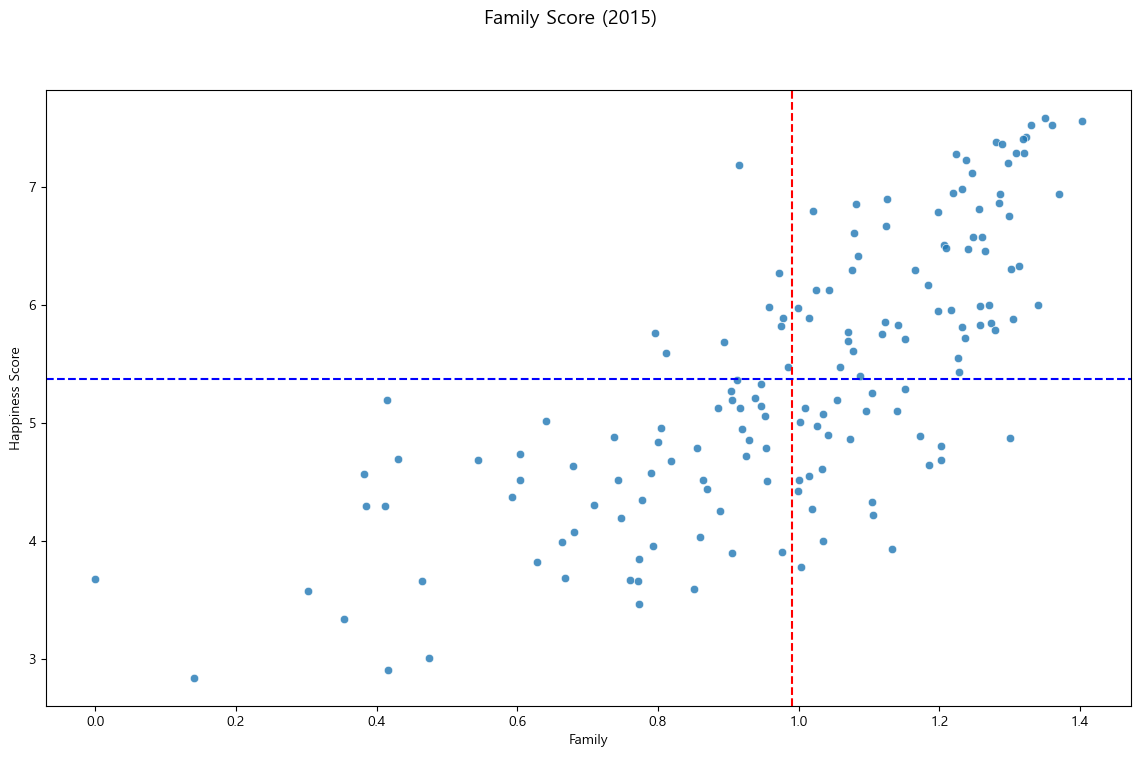

In [120]:
# scatter chart
plt.figure(figsize=(14, 8))

# scatter plot
sns.scatterplot(
    data=happiness_2015_numeric_df,
    x = 'Family',
    y = 'Happiness Score',
    alpha=0.8,
)

# 평균선 추가
plt.axvline(x=family_mean, color="red", linestyle="--", linewidth=1.5, label="Mean Family")
plt.axhline(y=score_mean, color="blue", linestyle="--", linewidth=1.5, label="Mean Happiness Score)")

# title
plt.suptitle('Family Score (2015)', fontsize=14)
plt.show()

##### summary

가족(Family) 지표 역시 전반적으로 행복지수와 양의 상관관계를 보이지만,<br />
**우하단(가족 점수는 높으나 행복지수가 낮은 국가)에 위치한 사례가 관측**된다.<br />
이는 가족 요인만으로는 행복지수를 충분히 설명하기 어려운 예외적 패턴이 존재함을 의미하며,<br />
이후 분석에서는 기대수명 등 다른 요인들과의 상관관계를 함께 고려한 분석이 필요하다.

#### health

##### visualization

In [118]:
# mean
health_mean = happiness_2015_numeric_df['Health (Life Expectancy)'].mean()

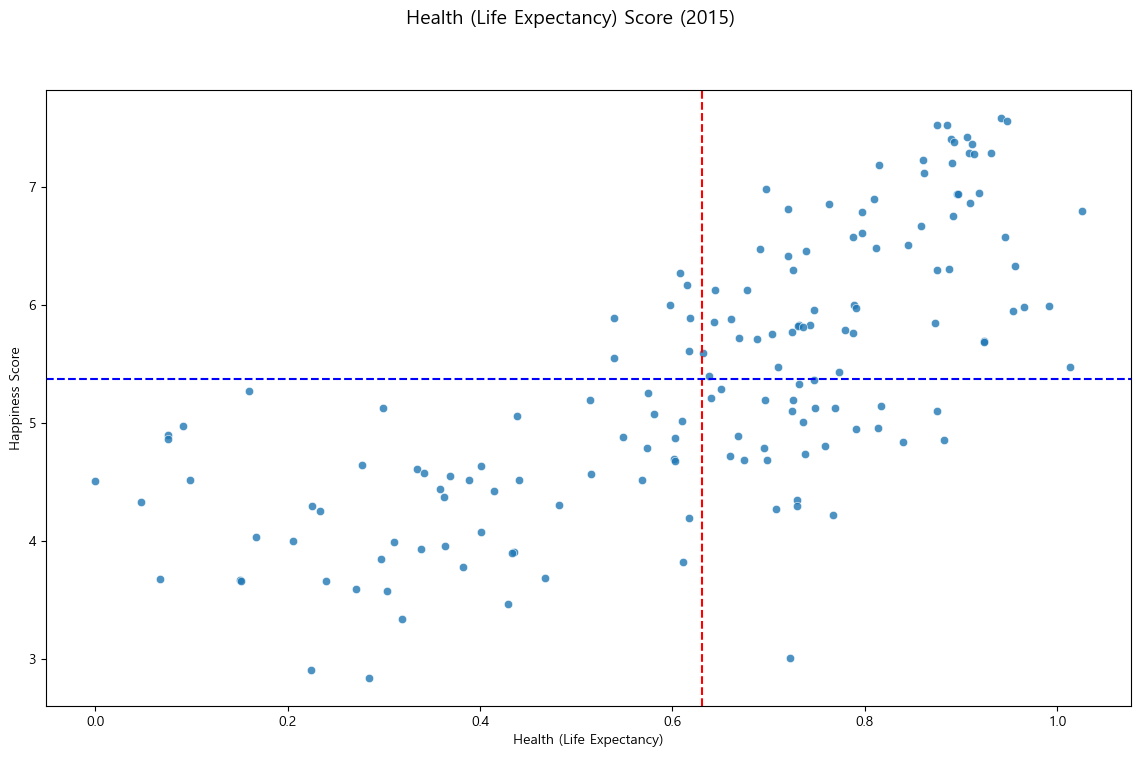

In [125]:
# scatter chart
plt.figure(figsize=(14, 8))

# scatter plot
sns.scatterplot(
    data=happiness_2015_numeric_df,
    x = 'Health (Life Expectancy)',
    y = 'Happiness Score',
    alpha=0.8,
)

# 평균선 추가
plt.axvline(x=health_mean, color="red", linestyle="--", linewidth=1.5, label="Mean Health (Life Expectancy)")
plt.axhline(y=score_mean, color="blue", linestyle="--", linewidth=1.5, label="Mean Happiness Score)")

# title
plt.suptitle('Health (Life Expectancy) Score (2015)', fontsize=14)
plt.show()

##### summary

기대수명(Health, Life Expectancy) 지표는 전반적으로 행복지수와 양의 상관관계를 보이지만,<br />
평균 기대수명 이상인 국가들 사이에서도 행복지수의 분산이 크게 나타난다.<br />
특히 **기대수명이 높음에도 평균 이하의 행복지수를 보이는 국가들이 존재**하여,<br />
기대수명 단일 지표만으로는 행복지수를 충분히 설명하기 어렵다는 점을 확인할 수 있다.<br />
따라서 기대수명은 행복지수에 **보조적인 영향을 미치는 요인으로 해석**되며,<br />
GDP 및 Family와 같은 다른 사회·경제적 요인과 함께 고려한 **다변량 분석이 필요**하다.

#### Correlation 3D visualization

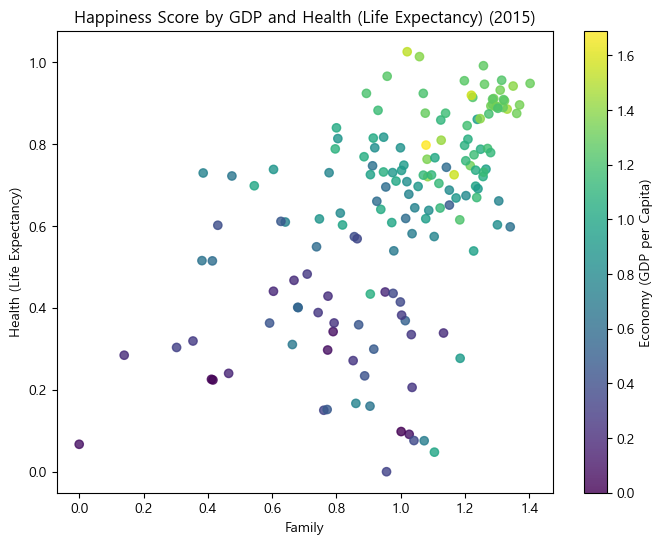

In [128]:
# GDP (Health and Family
plt.figure(figsize=(8, 6))
plt.scatter(
    happiness_2015_df["Family"],
    happiness_2015_df["Health (Life Expectancy)"],
    c=happiness_2015_df["Economy (GDP per Capita)"],
    cmap="viridis",
    alpha=0.8
)

plt.xlabel("Family")
plt.ylabel("Health (Life Expectancy)")
plt.title("Happiness Score by GDP and Health (Life Expectancy) (2015)")
plt.colorbar(label="Economy (GDP per Capita)")
plt.show()

##### summary

Family와 Health(기대수명)를 함께 고려한 산점도 분석 결과,<br />
**Family와 Health 수준이 모두 높은 국가들에서 GDP per capita가 높게 분포하는 경향**이 관측된다.<br />
이는 GDP가 단일 요인보다는 **Family 및 Health와 강하게 연관된 변수군과 함께 움직이는 구조**를 가짐을 시사한다.<br />
따라서 2015년 기준 데이터에서는 **GDP, Family, Health가 상호 밀접하게 연관된 핵심 설명 변수 군집**을 형성하고 있음을 확인할 수 있다.

### GDP로 설명이 안되는 국가들

#### Classifier Linear Regression model

In [130]:
# 선형 회귀 모델
from sklearn.linear_model import LinearRegression

In [136]:
# X는 Happiness Score에 상호 밀접하게 나타나는 Economy를 지정
# y는 Happiness Score를 지정
X = happiness_2015_numeric_df[['Economy (GDP per Capita)']]
y = happiness_2015_numeric_df['Happiness Score']

In [137]:
# 모델에 선형 회귀 지정
model = LinearRegression()

In [138]:
# 분류를 위해서 선형회귀 훈련
model.fit(X,y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


#### gdp pred and gdp residual columns add

In [139]:
# 구분 하기 위해서 gdb를 예측해서 gdp_pred 칼럼에 저장
happiness_2015_numeric_df['gdp_pred'] = model.predict(X)
# 분류 하기 위해서 원래 점수에서 예측 값을 뺸 값을 gdp_residual에 자장
happiness_2015_numeric_df['gdp_residual'] = y -  happiness_2015_numeric_df['gdp_pred']

In [140]:
threshold = happiness_2015_numeric_df['gdp_residual'].abs().quantile(0.8)

In [145]:
# gdp에 영향을 안 받는 행을 추출해서 gdp_outliers_df에 저장
gdp_outliers_df = happiness_2015_numeric_df[
    happiness_2015_numeric_df['gdp_residual'].abs() >= threshold
].copy()

In [146]:
# dataframe 확인
gdp_outliers_df.head()

,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,gdp_pred,gdp_residual
0,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,6.596586,0.990414
1,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,6.387651,1.173349
2,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,6.439025,1.087975
4,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,6.440822,0.986178
5,7.406,1.29025,1.31826,0.88911,0.64169,0.41372,0.23351,2.61955,6.360877,1.045123


#### outlier correlation

In [147]:
# 사용할 칼럼들 등록
cols = [
    "Happiness Score",
    "Family",
    "Health (Life Expectancy)",
    "Freedom",
    "Trust (Government Corruption)",
    "Generosity",
]

In [148]:
# gdp에 영향을 받지 않는 데이터를 기준으로 상관 관계 계산
outlier_corr = (
    gdp_outliers_df[cols]
    .corr(numeric_only=True)["Happiness Score"]
    .sort_values(ascending=False)
)

In [149]:
outlier_corr.head()

Happiness Score                  1.000000
Family                           0.799949
Freedom                          0.692898
Health (Life Expectancy)         0.631471
Trust (Government Corruption)    0.511901
Name: Happiness Score, dtype: float64

#### visualization

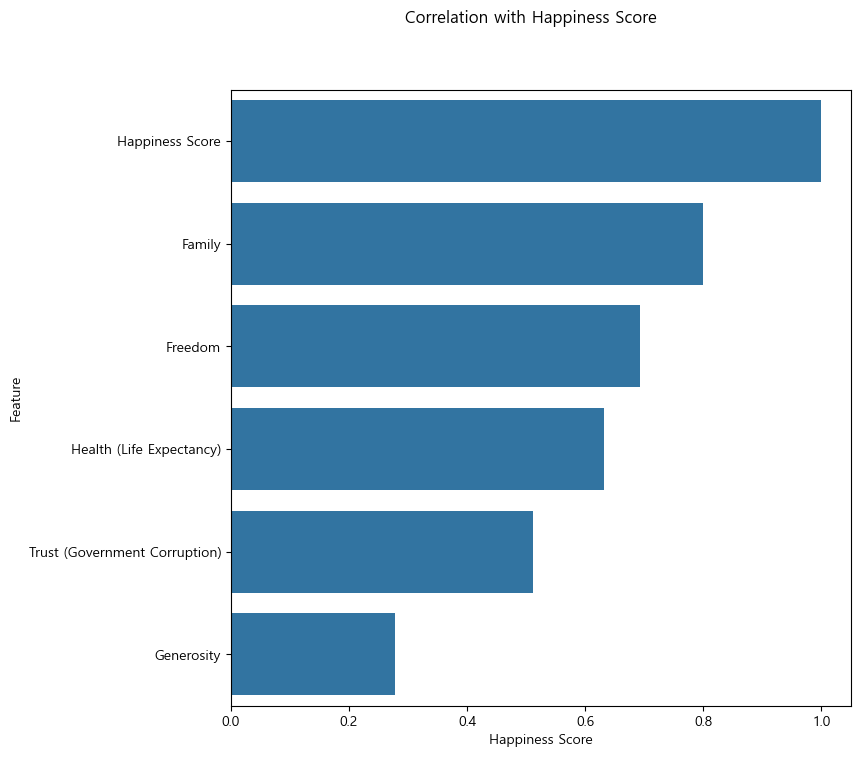

In [160]:
# 시각화 plot chart
plt.figure(figsize=(8,8))

sns.barplot(
    data=(
        outlier_corr
        .reset_index()
        .rename(columns={'index' : 'Feature'})
    ),
    x = 'Happiness Score',
    y = 'Feature',
    orient='h'
)

plt.suptitle('Correlation with Happiness Score')
plt.xlabel('Happiness Score')
plt.ylabel('Feature')
plt.show()

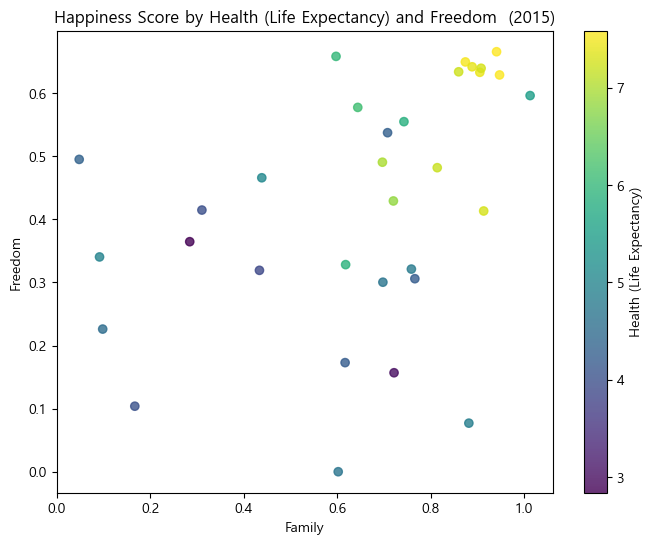

In [164]:
# GDP (Health and Family
plt.figure(figsize=(8, 6))
plt.scatter(
    gdp_outliers_df["Health (Life Expectancy)"],
    gdp_outliers_df["Freedom"],
    c=gdp_outliers_df["Happiness Score"],
    cmap="viridis",
    alpha=0.8
)

plt.xlabel("Family")
plt.ylabel("Freedom")
plt.title("Happiness Score by Health (Life Expectancy) and Freedom  (2015)")
plt.colorbar(label="Health (Life Expectancy)")
plt.show()

#### summary

GDP로 설명되지 않는 국가 집단을 대상으로 추가 분석한 결과,<br />
가족(Family)과 자유(Freedom)가 동시에 높은 국가들에서<br />
상대적으로 높은 행복지수가 관측되었다.<br />
또한 기대수명(Health)은 이러한 관계를 보완하는 요인으로 작용하며,<br />
행복지수는 단일 변수보다 사회적 요인의 결합 구조에 의해 형성되는 경향을 보였다.<br />
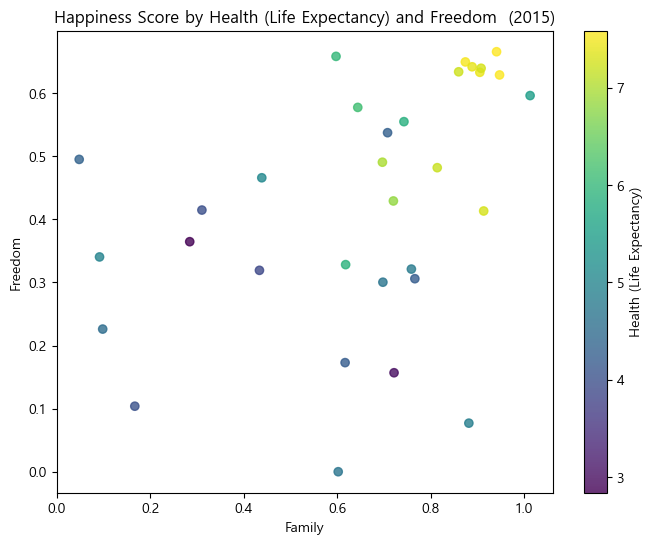

### Final Summary and Key Findings

본 분석은 2015년 행복 지수 데이터를 기반으로 행복 지수에 영향을 주는 관계를 탐색적으로 분석을 하였다.
1. 전체 국가를 대상으로 한 분석
    행복 지수는 **경제적 요건(1인당 GDP)에 강한 상관관계를 보였다.**
    경제적 요건은 **사회적 요건(가족, 자유)이 보완해 주는 관계를 확인했다.**
2. 다변량 시각화
    1인당 GDP가 높을 수록 **행복 지수가 증가하는 경향**이 나타났으나,
    1인당 GDP으로는 설명되지 않는 **예외적인 국가 집단**이 존재함을 확인하였다.
3. 1인당 GDP으로 설명되지 않는 집단
    이들 국가에서는 **가족과 자유의 요인이 상대적으로 강한 상관관계**를 보였다.
    이는 전체 국가를 대상으로 한 분석과는 **다른 양상**이다.

종합하면, 행복지수는 단일 경제 지표로 설명되기보다는 경제적 요인과 사회적 요인이 결합된 복합 구조를 가지며,<br />
국가 집단에 따라 그 설명 요인의 상대적 중요도가 달라질 수 있음을 시사한다.